In [1]:
#%matplotlib inline
#%matplotlib gtk
import sys
sys.path.insert(0, '../')
from pytest import approx
import fconcrete as fc
#import fconcrete
#from fconcrete import helpers, duplicated, Material, e, Beam, Node, Loads, Nodes, Load,Material, ConcreteBeam, SingleBeamElement, Rectangle, Concrete, Section, ConcreteSteels
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=3000)

#from math import log

# Tension in MPa
# length in cm
# Shear in kN

In [2]:
material = fc.Concrete(fck='20 MPa', aggressiveness=2)
section = fc.Rectangle(25,56, material)

f1 = fc.Load.UniformDistributedLoad(-0.1622, x_begin=0, x_end=113)
f2 = fc.Load.UniformDistributedLoad(-0.4994, x_begin=113, x_end=583)
f3 = fc.Load.UniformDistributedLoad(-0.4196, x_begin=583, x_end=1188)

n1 = fc.Node.SimpleSupport(x=0)
n2 = fc.Node.SimpleSupport(x=113)
n3 = fc.Node.SimpleSupport(x=583)
n4 = fc.Node.SimpleSupport(x=1188)

bar1 = fc.SingleBeamElement([n1, n2], section)
bar2 = fc.SingleBeamElement([n2, n3], section)
bar3 = fc.SingleBeamElement([n3, n4], section)


fc.config.available_material = {
"concrete_steel_bars":fc.AvailableConcreteSteelBar(
        diameters=[8]
)}
    
    
beam = fc.ConcreteBeam(
    loads = [f1, f2, f3],
    bars = [bar1, bar2, bar3]
)
self = beam

In [3]:
fc.config.available_material["concrete_steel_bars"].table

array([[-100. ,   -0.8,  -50. ],
       [ -99. ,   -0.8,  -49.5],
       [ -98. ,   -0.8,  -49. ],
       [ -97. ,   -0.8,  -48.5],
       [ -96. ,   -0.8,  -48. ],
       [ -95. ,   -0.8,  -47.5],
       [ -94. ,   -0.8,  -47. ],
       [ -93. ,   -0.8,  -46.5],
       [ -92. ,   -0.8,  -46. ],
       [ -91. ,   -0.8,  -45.5],
       [ -90. ,   -0.8,  -45. ],
       [ -89. ,   -0.8,  -44.5],
       [ -88. ,   -0.8,  -44. ],
       [ -87. ,   -0.8,  -43.5],
       [ -86. ,   -0.8,  -43. ],
       [ -85. ,   -0.8,  -42.5],
       [ -84. ,   -0.8,  -42. ],
       [ -83. ,   -0.8,  -41.5],
       [ -82. ,   -0.8,  -41. ],
       [ -81. ,   -0.8,  -40.5],
       [ -80. ,   -0.8,  -40. ],
       [ -79. ,   -0.8,  -39.5],
       [ -78. ,   -0.8,  -39. ],
       [ -77. ,   -0.8,  -38.5],
       [ -76. ,   -0.8,  -38. ],
       [ -75. ,   -0.8,  -37.5],
       [ -74. ,   -0.8,  -37. ],
       [ -73. ,   -0.8,  -36.5],
       [ -72. ,   -0.8,  -36. ],
       [ -71. ,   -0.8,  -35.5],
       [ -

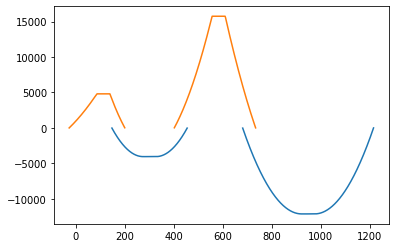

In [4]:
x_decalaged, momentum_positive, momentum_negative = beam.getDecalagedMomentumDiagram()
plt.plot(x_decalaged, -momentum_positive)
plt.plot(x_decalaged, -momentum_negative)
#x, y = beam.getShearDiagram()
#plt.plot(x, y)

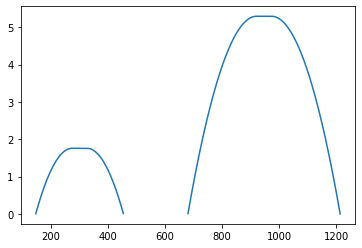

In [5]:
x, yp, yn = beam.getSteelAreaDiagram()
plt.plot(x, yp)
#x, y = beam.getShearDiagram()
#plt.plot(x, y)

# Rascunho

In [6]:
x, positive_areas_info, negative_areas_info = beam.getComercialSteelAreaDiagram()

In [7]:
quantity_positive, diameter_positive, area_positive = positive_areas_info

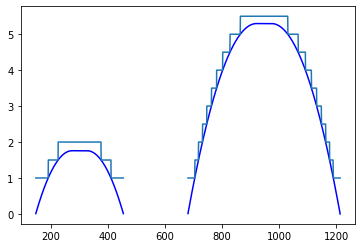

In [8]:
x, yp, yn = beam.getSteelAreaDiagram()
plt.plot(x, yp, 'b-')
plt.plot(x, area_positive)

In [8]:
def getInterspaceBetweenMomentum(x, area):
    '''
        Return an array and each row represents a interspace.
        Element row[0] is the begin of interspace and row[1], the end.
    '''
    previous_y=np.nan
    interspace = np.array([0, 0])
    for x_u,y in zip(x, area):
        if np.isnan(previous_y) and not np.isnan(y):
            begin = x_u
        elif np.isnan(y) and not np.isnan(previous_y):
            end = x_u
            interspace = np.vstack([interspace, [begin, end]])
        previous_y = y
    interspace = np.vstack([interspace, [begin, x[-1]]])[1:]
    return interspace

In [10]:
interspaces = getInterspaceBetweenMomentum(x, area_positive)

In [11]:
class SteelBars():
    def __init__(self, steelbars=[]):
        self.steelbars = np.array(steelbars)
    
    def add(self, steelbar):
        self.steelbars = np.append(self.steelbars,steelbar)
    
    def plot(self,prop='quantity'):
        for steelbar in self.steelbars:
            steelbar.plot(prop)
    
    def __getitem__(self, key):
        return self.steelbars[key]
    
    def __repr__(self):
        return str(self.steelbars)
        
class SteelBar():
    def __init__(self, long_begin, long_end, quantity, diameter):
        self.long_begin = long_begin
        self.long_end = long_end
        self.quantity = quantity
        self.diameter = diameter
    
    def plot(self,prop='quantity'):
        y = getattr(self, prop)
        plt.plot([self.long_begin, self.long_end], [y,y])
    
    def __repr__(self):
        return str(self.__dict__)+'\n'

In [12]:
def getBarsInInterspaces(x, areas_info):
    quantities, diameters, areas = areas_info  
    bars = SteelBars()
    
    for interspace in getInterspaceBetweenMomentum(x, area_positive):
        is_in_interpace = (x > interspace[0]) & (x<interspace[1])
        x_interspace = x[is_in_interpace]
        quantities_interspace = quantities[is_in_interpace]
        diameter = diameters[is_in_interpace][0]

        max_quantity_interspace = int(max(quantities_interspace))

        for quantity in range(1, max_quantity_interspace+1):
            x_same_quantity = x_interspace[quantities_interspace == quantity]
            if len(x_same_quantity)>0:
                new_bar = SteelBar(long_begin=min(x_same_quantity),
                                   long_end=max(x_same_quantity),
                                   quantity=quantity,
                                   diameter=diameter)
                bars.add(new_bar)

    return bars

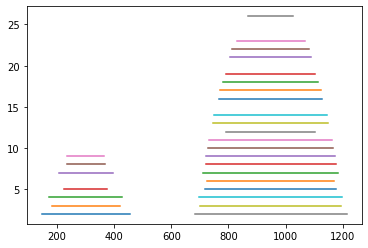

In [14]:
getBarsInInterspaces(x, positive_areas_info).plot()


In [69]:
new_bar = SteelBar(long_begin=0,
                                   long_end=2,
                                   quantity=5,
                                   diameter=0.1)

In [77]:
getattr(new_bar, 'quantity')

5

In [72]:
new_bar['quantity']

TypeError: 'SteelBar' object is not subscriptable

In [71]:
new_bar.plot()

TypeError: 'SteelBar' object is not subscriptable

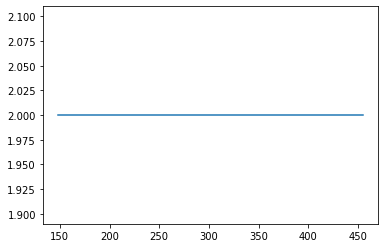

In [27]:
plt.plot([148.311,454.608], [2, 2])

In [13]:
yp[np.isnan(yp)]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

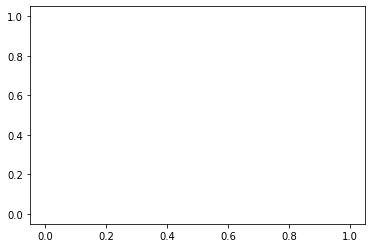

In [11]:
a = x[np.isnan(yp)]
b = yp[np.isnan(yp)]
plt.plot(a, b)

In [80]:
yp[np.isnan(yp)]

TypeError: only integer scalar arrays can be converted to a scalar index

In [49]:
number_of_bars[~np.isnan(number_of_bars)]

array([2., 2., 2., ..., 2., 2., 2.])

In [51]:
bar_removal = number_of_bars.copy()
for number in np.unique(number_of_bars[~np.isnan(number_of_bars)]):
    bar_removal = np.vstack([bar_removal, number*(number_of_bars==number)])
bar_removal = bar_removal[1:]

In [52]:
bar_removal = np.where(bar_removal==0, np.nan, bar_removal)

In [53]:
bar_removal

array([[nan, nan, nan, ...,  2.,  2.,  2.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

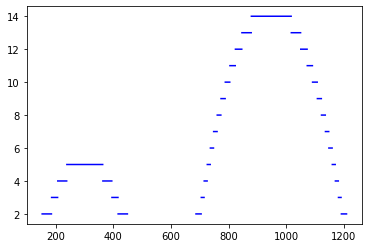

In [54]:
for bar in bar_removal:
    plt.plot(x, bar, 'b')
    
plt.show()

In [57]:
a = np.array([1, 2, 4])
a1 = np.vstack([a, [5,6,6]])
a2 = np.vstack([a1, [5,6,6]])

In [55]:
a2

array([[1, 2, 4],
       [5, 6, 6],
       [5, 6, 6]])

In [35]:
np.array([np.array([[1,2,3],[4,5,6]]),np.array([5,7,8])])

array([array([[1, 2, 3],
       [4, 5, 6]]), array([5, 7, 8])], dtype=object)

In [55]:
x, necessary_area = beam.getSteelAreaDiagram()
x, y = beam.getComercialSteelAreaDiagram()
number_of_bars = np.array(y)[:,0]
bar_diameter = np.array(y)[:,1]
comercial_area = np.array(y)[:,2]

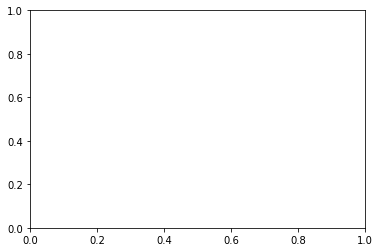

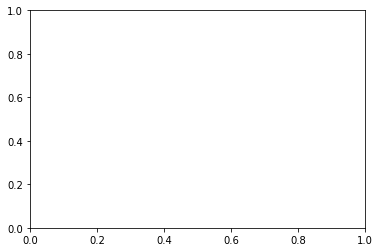

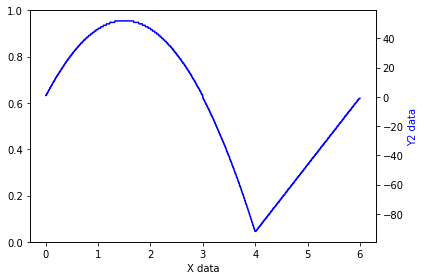

In [69]:
plt.cla()
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
#ax1.plot(x, comercial_area, 'g-')
ax2.plot(x, number_of_bars, 'b-')

ax1.set_xlabel('X data')
#ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [7]:
gapminder_us = gapminder[gapminder.country=="United States"]

Text(0,0.5,'Y2 data')

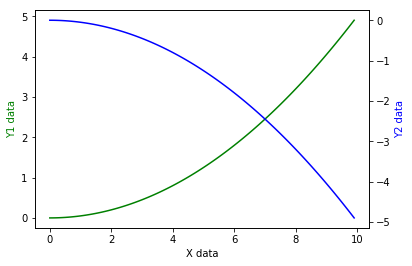

In [49]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(0, 10, 0.1)
y1 = 0.05 * x**2
y2 = -1 *y1

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')

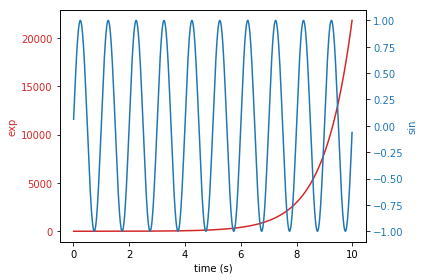

In [67]:
import matplotlib.pyplot as plt

# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
